In [1]:
from tensorflow.keras import models, layers, utils, backend as K
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

In [2]:
import imblearn as imb

In [3]:
from google.colab import drive
drive.mount('/content/drive')
data = pd.read_csv('/content/drive/MyDrive/MVI-semestralka/Data/sampled_united_bothqs.csv')
data.info()

Mounted at /content/drive
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101071 entries, 0 to 101070
Columns: 771 entries, Unnamed: 0 to emb02_383
dtypes: float64(770), int64(1)
memory usage: 594.5 MB


In [4]:
data = data.drop(columns=['Unnamed: 0', 'id'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101071 entries, 0 to 101070
Columns: 769 entries, is_duplicate to emb02_383
dtypes: float64(769)
memory usage: 593.0 MB


In [5]:
from sklearn.metrics import confusion_matrix

# define metrics
def Recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def Precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def F1(y_true, y_pred):
    precision = Precision(y_true, y_pred)
    recall = Recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))



In [19]:
#First neural network, simple two layers
n_features = 768
model = models.Sequential(name="FirstNN", layers=[
    ### hidden layer 1
    layers.Dense(name="h1", input_dim=n_features,
                 units=int(round((n_features+1)/2)), 
                 activation='relu'),
    layers.Dropout(name="drop1", rate=0.2),
    
    ### hidden layer 2
    layers.Dense(name="h2", units=int(round((n_features+1)/4)), 
                 activation='relu'),
    layers.Dropout(name="drop2", rate=0.2),
    
    ### layer output
    layers.Dense(name="output", units=1, activation='sigmoid')
])
model.summary()

# compile the neural network
model.compile(optimizer='adam', loss='binary_crossentropy', 
              metrics=['accuracy',F1, 'TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives'])

Model: "FirstNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 h1 (Dense)                  (None, 384)               295296    
                                                                 
 drop1 (Dropout)             (None, 384)               0         
                                                                 
 h2 (Dense)                  (None, 192)               73920     
                                                                 
 drop2 (Dropout)             (None, 192)               0         
                                                                 
 output (Dense)              (None, 1)                 193       
                                                                 
Total params: 369,409
Trainable params: 369,409
Non-trainable params: 0
_________________________________________________________________


In [6]:
#Sampling the data, in the end I used nearly everything
data_sampled = data.sample(100000)
data_sampled.is_duplicate.mean()

0.37127

In [7]:
y = data_sampled.is_duplicate
X = data_sampled.drop(columns='is_duplicate')
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 18044 to 75219
Columns: 768 entries, emb01_0 to emb02_383
dtypes: float64(768)
memory usage: 586.7 MB


Epoch 1/50
2188/2188 - 10s - loss: 0.0174 - accuracy: 0.9938 - F1: 0.9912 - true_positives: 25828.0000 - true_negatives: 43739.0000 - false_positives: 228.0000 - false_negatives: 205.0000 - val_loss: 1.0550 - val_accuracy: 0.8289 - val_F1: 0.7613 - val_true_positives: 8580.0000 - val_true_negatives: 16287.0000 - val_false_positives: 2653.0000 - val_false_negatives: 2480.0000 - 10s/epoch - 5ms/step
Epoch 2/50
2188/2188 - 10s - loss: 0.0162 - accuracy: 0.9946 - F1: 0.9923 - true_positives: 25867.0000 - true_negatives: 43754.0000 - false_positives: 213.0000 - false_negatives: 166.0000 - val_loss: 1.0821 - val_accuracy: 0.8281 - val_F1: 0.7606 - val_true_positives: 8601.0000 - val_true_negatives: 16242.0000 - val_false_positives: 2698.0000 - val_false_negatives: 2459.0000 - 10s/epoch - 5ms/step
Epoch 3/50
2188/2188 - 10s - loss: 0.0171 - accuracy: 0.9939 - F1: 0.9913 - true_positives: 25842.0000 - true_negatives: 43729.0000 - false_positives: 238.0000 - false_negatives: 191.0000 - val_loss

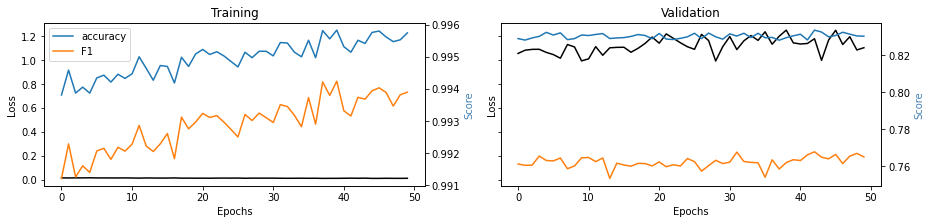

In [ ]:
#Taken from tutorial at towards data science
# train/validation
training = model.fit(x=X, y=y, batch_size=32, epochs=50, shuffle=True, verbose=2, validation_split=0.3)
# plot
metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]    
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15,3))
       
## training    
ax[0].set(title="Training")    
ax11 = ax[0].twinx()    
ax[0].plot(training.history['loss'], color='black')    
ax[0].set_xlabel('Epochs')    
ax[0].set_ylabel('Loss', color='black')    
for metric in metrics:  
    if 'false' in metric or 'true' in metric:
      continue      
    ax11.plot(training.history[metric], label=metric)    
ax11.set_ylabel("Score", color='steelblue')    
ax11.legend()
        
## validation    
ax[1].set(title="Validation")    
ax22 = ax[1].twinx()    
ax[1].plot(training.history['val_loss'], color='black')    
ax[1].set_xlabel('Epochs')    
ax[1].set_ylabel('Loss', color='black')    
for metric in metrics:
    if 'false' in metric or 'true' in metric:
      continue         
    ax22.plot(training.history['val_'+metric], label=metric)    
ax22.set_ylabel("Score", color="steelblue")    
plt.show()

In [10]:
#Test another model
def test_network(model_to_test, y_test, x_test):
  print("Testing model: " + model_to_test.name)
  # train/validation
  training = model_to_test.fit(x=x_test, y=y_test, batch_size=32, epochs=50, shuffle=True, verbose=2, validation_split=0.3)
  # plot
  metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]    
  fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15,3))
       
  ## training    
  ax[0].set(title="Training")    
  ax11 = ax[0].twinx()    
  ax[0].plot(training.history['loss'], color='black')    
  ax[0].set_xlabel('Epochs')    
  ax[0].set_ylabel('Loss', color='black')    
  for metric in metrics:  
      if 'false' in metric or 'true' in metric:
        continue      
      ax11.plot(training.history[metric], label=metric)    
  ax11.set_ylabel("Score", color='steelblue')    
  ax11.legend()
        
  ## validation    
  ax[1].set(title="Validation")    
  ax22 = ax[1].twinx()    
  ax[1].plot(training.history['val_loss'], color='black')    
  ax[1].set_xlabel('Epochs')    
  ax[1].set_ylabel('Loss', color='black')    
  for metric in metrics:
      if 'false' in metric or 'true' in metric:
        continue         
      ax22.plot(training.history['val_'+metric], label=metric)    
  ax22.set_ylabel("Score", color="steelblue")    
  plt.show()

In [9]:
#Using regularization
n_features = 768
model = models.Sequential(name="RegularizationNN", layers=[
    ### hidden layer 1
    layers.Dense(name="h1", input_dim=n_features,
                 units=int(round((n_features+1)/2)), 
                 activation='relu', kernel_regularizer='l2'),
    layers.Dropout(name="drop1", rate=0.2),
    
    ### hidden layer 2
    layers.Dense(name="h2", units=int(round((n_features+1)/4)), 
                 activation='relu', kernel_regularizer='l2'),
    layers.Dropout(name="drop2", rate=0.2),
    
    ### layer output
    layers.Dense(name="output", units=1, activation='sigmoid')
])
model.summary()

# compile the neural network
model.compile(optimizer='adam', loss='binary_crossentropy', 
              metrics=['accuracy',F1, 'TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives'])

Model: "RegularizationNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 h1 (Dense)                  (None, 384)               295296    
                                                                 
 drop1 (Dropout)             (None, 384)               0         
                                                                 
 h2 (Dense)                  (None, 192)               73920     
                                                                 
 drop2 (Dropout)             (None, 192)               0         
                                                                 
 output (Dense)              (None, 1)                 193       
                                                                 
Total params: 369,409
Trainable params: 369,409
Non-trainable params: 0
_________________________________________________________________


Epoch 1/50
2188/2188 - 21s - loss: 0.7365 - accuracy: 0.6659 - F1: 0.2699 - true_positives: 5133.0000 - true_negatives: 41483.0000 - false_positives: 2529.0000 - false_negatives: 20855.0000 - val_loss: 0.6548 - val_accuracy: 0.6676 - val_F1: 0.2256 - val_true_positives: 1565.0000 - val_true_negatives: 18463.0000 - val_false_positives: 440.0000 - val_false_negatives: 9532.0000 - 21s/epoch - 10ms/step
Epoch 2/50
2188/2188 - 17s - loss: 0.6340 - accuracy: 0.6891 - F1: 0.4310 - true_positives: 8960.0000 - true_negatives: 39276.0000 - false_positives: 4736.0000 - false_negatives: 17028.0000 - val_loss: 0.6335 - val_accuracy: 0.6881 - val_F1: 0.3618 - val_true_positives: 2849.0000 - val_true_negatives: 17793.0000 - val_false_positives: 1110.0000 - val_false_negatives: 8248.0000 - 17s/epoch - 8ms/step
Epoch 3/50
2188/2188 - 16s - loss: 0.6260 - accuracy: 0.6995 - F1: 0.4648 - true_positives: 9872.0000 - true_negatives: 39090.0000 - false_positives: 4922.0000 - false_negatives: 16116.0000 - va

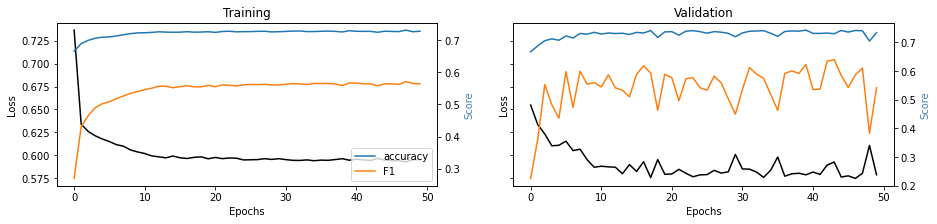

In [ ]:
test_network(model, y, X)

In [ ]:
n_features = 768
model = models.Sequential(name="RegularizationNN02", layers=[
    ### hidden layer 1
    layers.Dense(name="h1", input_dim=n_features,
                 units=int(round((n_features+1)/2)), 
                 activation='relu', kernel_regularizer='l2'),
    layers.Dropout(name="drop1", rate=0.2),
    
    ### hidden layer 2
    layers.Dense(name="h2", units=int(round((n_features+1)/4)), 
                 activation='relu', kernel_regularizer='l2'),
    layers.Dropout(name="drop2", rate=0.2),

    ### hidden layer 2
    layers.Dense(name="h3", units=int(round((n_features+1)/4)), 
                 activation='tanh'),
    layers.Dropout(name="drop3", rate=0.2),
    
    ### layer output
    layers.Dense(name="output", units=1, activation='sigmoid')
])
model.summary()

# compile the neural network
model.compile(optimizer='adam', loss='binary_crossentropy', 
              metrics=['accuracy',F1, 'TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives'])

Model: "RegularizationNN02"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 h1 (Dense)                  (None, 384)               295296    
                                                                 
 drop1 (Dropout)             (None, 384)               0         
                                                                 
 h2 (Dense)                  (None, 192)               73920     
                                                                 
 drop2 (Dropout)             (None, 192)               0         
                                                                 
 h3 (Dense)                  (None, 192)               37056     
                                                                 
 drop3 (Dropout)             (None, 192)               0         
                                                                 
 output (Dense)              (None, 1)          

Epoch 1/50
2188/2188 - 23s - loss: 0.7217 - accuracy: 0.6970 - F1: 0.4554 - true_positives: 10029.0000 - true_negatives: 38762.0000 - false_positives: 5250.0000 - false_negatives: 15959.0000 - val_loss: 0.6212 - val_accuracy: 0.7238 - val_F1: 0.5966 - val_true_positives: 6436.0000 - val_true_negatives: 15279.0000 - val_false_positives: 3624.0000 - val_false_negatives: 4661.0000 - 23s/epoch - 11ms/step
Epoch 2/50
2188/2188 - 21s - loss: 0.6190 - accuracy: 0.7168 - F1: 0.5361 - true_positives: 12216.0000 - true_negatives: 37961.0000 - false_positives: 6051.0000 - false_negatives: 13772.0000 - val_loss: 0.5991 - val_accuracy: 0.7329 - val_F1: 0.5575 - val_true_positives: 5341.0000 - val_true_negatives: 16646.0000 - val_false_positives: 2257.0000 - val_false_negatives: 5756.0000 - 21s/epoch - 10ms/step
Epoch 3/50
2188/2188 - 22s - loss: 0.6101 - accuracy: 0.7251 - F1: 0.5607 - true_positives: 13181.0000 - true_negatives: 37578.0000 - false_positives: 6434.0000 - false_negatives: 12807.0000

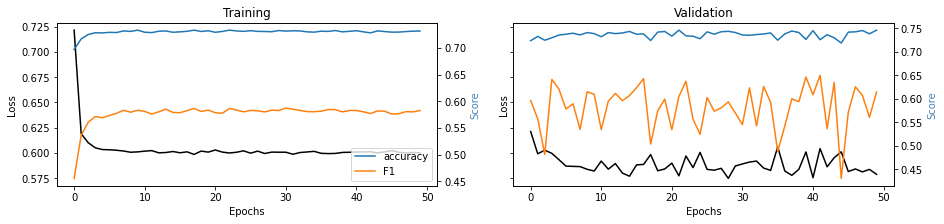

In [ ]:
test_network(model, y, X)

In [8]:
oversampler = imb.over_sampling.RandomOverSampler()
print(len(y))
x_over, y_over = oversampler.fit_resample(X, y)
print(len(y_over))

100000
125746


In [ ]:
#First neural network, simple two layers
n_features = 768
model = models.Sequential(name="FirstNN", layers=[
    ### hidden layer 1
    layers.Dense(name="h1", input_dim=n_features,
                 units=int(round((n_features+1)/2)), 
                 activation='relu'),
    layers.Dropout(name="drop1", rate=0.2),
    
    ### hidden layer 2
    layers.Dense(name="h2", units=int(round((n_features+1)/4)), 
                 activation='relu'),
    layers.Dropout(name="drop2", rate=0.2),
    
    ### layer output
    layers.Dense(name="output", units=1, activation='sigmoid')
])
model.summary()

# compile the neural network
model.compile(optimizer='adam', loss='binary_crossentropy', 
              metrics=['accuracy',F1, 'TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives'])

Testing model: FirstNN
Epoch 1/50
2751/2751 - 22s - loss: 0.4806 - accuracy: 0.7609 - F1: 0.6328 - true_positives: 19789.0000 - true_negatives: 47184.0000 - false_positives: 8208.0000 - false_negatives: 12841.0000 - val_loss: 0.5079 - val_accuracy: 0.7632 - val_F1: 0.8078 - val_true_positives: 22368.0000 - val_true_negatives: 6424.0000 - val_false_positives: 1057.0000 - val_false_negatives: 7875.0000 - 22s/epoch - 8ms/step
Epoch 2/50
2751/2751 - 18s - loss: 0.3680 - accuracy: 0.8269 - F1: 0.7624 - true_positives: 25519.0000 - true_negatives: 47270.0000 - false_positives: 8122.0000 - false_negatives: 7111.0000 - val_loss: 0.3751 - val_accuracy: 0.8493 - val_F1: 0.8717 - val_true_positives: 25844.0000 - val_true_negatives: 6196.0000 - val_false_positives: 1285.0000 - val_false_negatives: 4399.0000 - 18s/epoch - 7ms/step
Epoch 3/50
2751/2751 - 16s - loss: 0.3130 - accuracy: 0.8578 - F1: 0.8055 - true_positives: 27217.0000 - true_negatives: 48287.0000 - false_positives: 7105.0000 - false_n

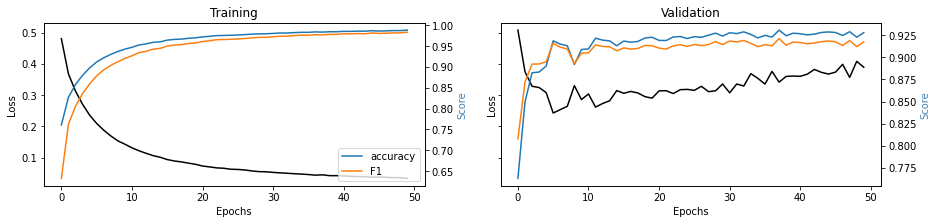

In [15]:
test_network(model, y_over, x_over)

In [18]:
undersampler = imb.under_sampling.RandomUnderSampler()
print(len(y))
X_under, y_under = undersampler.fit_resample(X, y)
print(len(y_under))

100000
74254


In [ ]:
#First neural network, simple two layers
n_features = 768
model = models.Sequential(name="FirstNN", layers=[
    ### hidden layer 1
    layers.Dense(name="h1", input_dim=n_features,
                 units=int(round((n_features+1)/2)), 
                 activation='relu'),
    layers.Dropout(name="drop1", rate=0.2),
    
    ### hidden layer 2
    layers.Dense(name="h2", units=int(round((n_features+1)/4)), 
                 activation='relu'),
    layers.Dropout(name="drop2", rate=0.2),
    
    ### layer output
    layers.Dense(name="output", units=1, activation='sigmoid')
])
model.summary()

# compile the neural network
model.compile(optimizer='adam', loss='binary_crossentropy', 
              metrics=['accuracy',F1, 'TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives'])

In [21]:
test_network(model, y_under, X_under)

Testing model: FirstNN
Epoch 1/50
1625/1625 - 13s - loss: 0.4758 - accuracy: 0.7739 - F1: 0.4688 - true_positives: 5919.0000 - true_negatives: 34308.0000 - false_positives: 2819.0000 - false_negatives: 8931.0000 - val_loss: 0.8620 - val_accuracy: 0.5171 - val_F1: 0.6772 - val_true_positives: 11519.0000 - val_true_negatives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_false_negatives: 10758.0000 - 13s/epoch - 8ms/step
Epoch 2/50
1625/1625 - 10s - loss: 0.3671 - accuracy: 0.8271 - F1: 0.6623 - true_positives: 9418.0000 - true_negatives: 33574.0000 - false_positives: 3553.0000 - false_negatives: 5432.0000 - val_loss: 0.7032 - val_accuracy: 0.6468 - val_F1: 0.7821 - val_true_positives: 14409.0000 - val_true_negatives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_false_negatives: 7868.0000 - 10s/epoch - 6ms/step
Epoch 3/50
1625/1625 - 11s - loss: 0.3029 - accuracy: 0.8627 - F1: 0.7451 - true_positives: 11064.0000 - true_negatives: 33778.0000 - false_positives: 3349.0000 - false